### 2.3 Clustering!

1)  Implement the K-means clustering algorithm (**not** ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2)  Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3)  Run the algorithm on the data obtained from the dimensionality reduction.

4)  Implement **K-means++** from scratch and explain the differences with the results you got earlier.

5)  Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

In [4]:
# Libraries

import numpy as np
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt


def initialize_centroids_random(data, k):
    return data.takeSample(False, k)


def assign_to_nearest_centroid(data, centroids):
    return data.map(
        lambda point: (
            np.argmin([np.linalg.norm(point - centroid) for centroid in centroids]),
            point,
        )
    )


def recompute_centroids(data_assigned):
    return (
        data_assigned.groupByKey()
        .mapValues(lambda points: np.mean(list(points), axis=0))
        .sortByKey()
        .values()
        .collect()
    )


def kmeans(data, k, centroid_init, max_iterations=100, tolerance=0.00001):
    # Function will be one of the parameters
    centroids = centroid_init(data, k)
    for _ in range(max_iterations):
        last_centroids = centroids

        # MapReduce Steps:
        # Map step: Assign each point to the nearest centroid
        assigned_data = assign_to_nearest_centroid(data, centroids)

        # Reduce step: Calculate new centroids
        centroids = recompute_centroids(assigned_data)

        # Check for convergence
        centroids_shift = sum(
            np.linalg.norm(np.array(centroid) - np.array(last_centroid))
            for centroid, last_centroid in zip(centroids, last_centroids)
        )
        if centroids_shift < tolerance:
            break

    return centroids


def kmeans_random(data, k, max_iterations=100, tolerance=0.00001):
    # Wrapper for kmeans random 
    return kmeans(
        data,
        k,
        centroid_init=initialize_centroids_random,
        max_iterations=max_iterations,
        tolerance=tolerance,
    )

In [2]:
def calculate_SSE(data, centroids):
    return data.map(
        lambda point: min(
            np.linalg.norm(point - centroid) ** 2 for centroid in centroids
        )
    ).sum()


def silhouette_score(data, centroids):
    def compute_distances(point):
        distances = np.array(
            [np.linalg.norm(point - centroid) for centroid in centroids]
        )
        closest, second_closest = np.partition(distances, 1)[:2]
        return closest, second_closest

    scores = data.map(lambda point: compute_distances(point)).collect()
    a = np.mean([s[0] for s in scores])
    b = np.mean([s[1] for s in scores])
    return (b - a) / max(a, b)

In [22]:
spark = SparkSession.builder.appName("K-means Clustering").getOrCreate()

# Loading data
data_spark = spark.read.csv("final_df_normalized.csv", header=True, inferSchema=True)

# Feature names which will be used
feature_names = [
    "average_click_duration",
    "average_duration_per_day",
    "tot_movie_watched",
    "num_of_days",
    "average_release_year",
    "max_time_spent_watching",
    "frequency",
    "average_weekend_click_duration",
]

# Conversion to rdd
data_rdd = data_spark.rdd.map(lambda row: np.array([row[col] for col in feature_names]))

sse_list = []
silhouette_scores = []
for k in range(2, 15):
    centroids = kmeans_random(data_rdd, k)
    sse = calculate_SSE(data_rdd, centroids)
    score = silhouette_score(data_rdd, centroids)
    sse_list.append(sse)
    silhouette_scores.append(score)

23/12/13 03:14:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


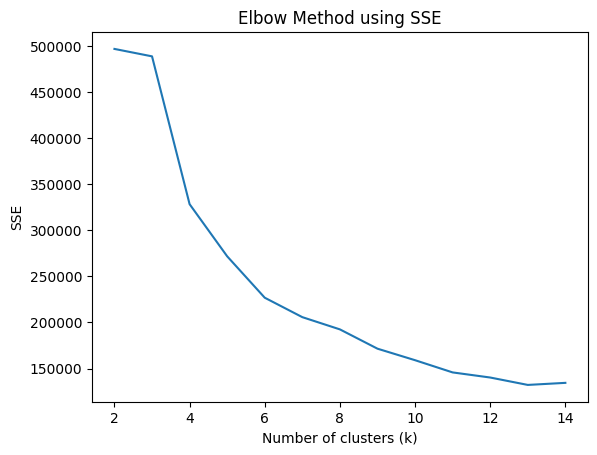

In [23]:
plt.plot(range(2, 15), sse_list)
plt.title("Elbow Method using SSE")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

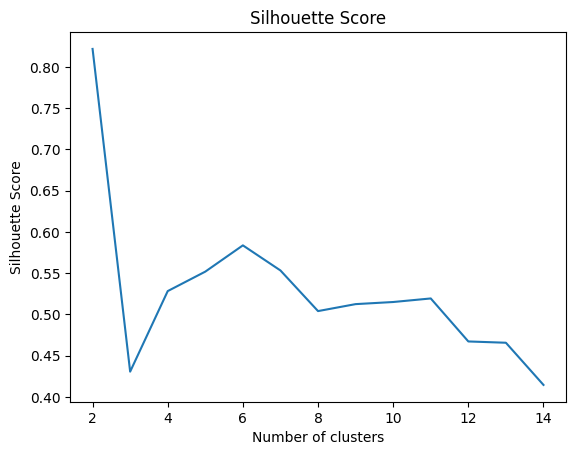

In [24]:
plt.plot(range(2, 15), silhouette_scores)
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [25]:
spark.stop()